In [1]:
# Libraries

# Agent-based modeling
import mesa

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data manipulation
import numpy as np
import pandas as pd

# Calculations
import math

In [2]:
## metrics used

# gini index
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B

# (A) sensitive attribute
    # individuals from group A1
    # infividiuals from group A2

# company's cost increase as they provide service to more areas
# areas where A1 live have a higher earning, which is why company discriminates 
    # addition will be made: company will make more money if they provide service to A1 areas

# Fair Scenario

In [ ]:
# this will be added to the model, essentially it's the same as the step k case with k = 0 (Check bottom)

# Discrimination Scenario

We use square root utility function for diminishing marginal utility.


In [3]:
# Set the coordinates of discriminated neighborhoods
discriminated_neighborhoods = [(0, 0), (3, 3)]

In [4]:
class MoneyAgent(mesa.Agent):

    def __init__(self, unique_id, model, initial_neighborhood):
        super().__init__(unique_id, model)
        self.life_quality = 0.1  # Initialize life quality
        self.initial_neighborhood = initial_neighborhood  # Track initial neighborhood
        self.wealth = self.assign_initial_wealth(initial_neighborhood)  # Initialize wealth based on neighborhood

    # might change back to constant initial wealth
    def assign_initial_wealth(self, neighborhood):
        # Define wealth distribution based on neighborhood
        if neighborhood == "Discriminated":
            return self.random.normalvariate(4, 2)  # Poor neighborhood
        else:
            return self.random.normalvariate(6, 2)  # Wealthy neighborhood

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        cellmates.pop(cellmates.index(self))  # Ensure agent is not giving money to itself
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 0.01 * (1 + other.life_quality)
            self.wealth -= 0.01

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

class ServiceCompany:
    def __init__(self, model, discriminated_neighborhoods, life_qual_multiplier):
        self.model = model
        self.discriminated_neighborhoods = discriminated_neighborhoods
        self.life_qual_multiplier = life_qual_multiplier
        self.profit_current = 0.01  # Initialize profit_current
        self.profit = []  # Initialize profit list
        self.cost = []  # Initialize cost list

    def provide_service(self):
        width, height = self.model.grid.width, self.model.grid.height
        profit = 0  # Initialize profit for this step
        cost = 0  # Initialize cost for this step
        for x in range(width):
            for y in range(height):
                for content in self.model.grid.get_cell_list_contents((x, y)):
                    agent = content
                    if agent.initial_neighborhood == "Non-Discriminated":
                        # Provide service to agents whose initial neighborhood is not discriminated
                        agent.life_quality = math.sqrt(agent.life_quality * (1 + self.life_qual_multiplier))
                        profit += (10*(self.profit_current**2) /(100 + self.profit_current**3))   # Calculate profit for this agent using profit_current
                        cost += 0.02  # Increase company's cost for providing service for this step
        # Append profit and cost for this step to their respective lists
        self.profit.append(profit)
        self.cost.append(cost)
        self.profit_current += 0.1  # Update profit_current with the profit calculated for this step

    def calculate_total_profit(self):
        # Calculate total profit by summing up profit over all steps and subtracting total cost
        total_revenue = sum(self.profit)  # Each service provided contributes to revenue by 1 unit
        total_cost = sum(self.cost)
        total_profit = total_revenue - total_cost
        return total_profit

In [ ]:
# Define MoneyModelWithCompany class
class MoneyModelWithCompany(mesa.Model):
    def __init__(self, N, width, height, discriminated_neighborhoods, life_qual_multiplier):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.company = ServiceCompany(self, discriminated_neighborhoods, life_qual_multiplier)  # Include life_qual_multiplier

        # Create agents
        for i in range(self.num_agents):
            initial_neighborhood = self.random.choice(["Discriminated", "Non-Discriminated"])
            a = MoneyAgent(i, self, initial_neighborhood)  # Pass initial neighborhood
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini,
                             "CompanyProfit": lambda m: m.company.profit},
            agent_reporters={"Wealth": "wealth",
                             "InitialNeighborhood": "initial_neighborhood"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.company.provide_service()

In [ ]:
# Set the coordinates of discriminated neighborhoods
discriminated_neighborhoods = [(0, 0), (3, 3)]

# Define the life quality multiplier
life_qual_multiplier = 0.1

# Create an instance of MoneyModelWithCompany
model = MoneyModelWithCompany(100, 10, 10, discriminated_neighborhoods, life_qual_multiplier)

# Run the simulation
for i in range(10000):
    model.step()  # Step the model

In [ ]:
# Calculate the profit of the company
total_profit = model.company.calculate_total_profit()
print("Total Profit:", total_profit)

In [ ]:
model_data = model.datacollector.get_model_vars_dataframe()


In [ ]:
model_data

In [ ]:
# Plot the company's marginal profit over time
marginal_profit = model.company.profit
plt.plot(range(10000), marginal_profit, label="Profit")
#plt.plot(range(200), model.company.cost, label="Cost")
plt.xlabel("Time Step")
plt.ylabel("Amount")
plt.title("Company's Marginal Profit")
plt.legend()
plt.xlim(-5, 205)

plt.show()

'''# Assuming you have already run the model and collected data
# Get the profit data from the data collector
model_data = model.datacollector.get_model_vars_dataframe()

# Plot the profit over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=model_data["CompanyProfit"])
plt.title("Company Profit over Time")
plt.xlabel("Steps")
plt.ylabel("Profit")
plt.show()
'''

In [ ]:
# Plot the company's profit over time
marginal_profit = model.company.profit
cumulative_profit = np.cumsum(marginal_profit)  # Calculate cumulative sum of profit

plt.plot(range(10000), cumulative_profit, label="Cumulative Profit")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Profit")
plt.title("Company's Cumulative Profit")
plt.legend()
plt.xlim(-5, 10005)  # Adjust x-axis limit if needed

plt.show()


In [ ]:
# Plot the Gini coefficient over time
g = sns.lineplot(data=model_data["Gini"])
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

In [ ]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

In [ ]:
# 2. Plot the Wealth of Agents Over Time

# Plot the wealth of agents from discriminated neighborhoods over time
sns.lineplot(data=agent_wealth, x="Step", y="Wealth", hue="InitialNeighborhood")
plt.title("Wealth of agents over time")
plt.xlabel("Step")
plt.ylabel("Wealth")
plt.show()

In [ ]:
# Filter the data to include only steps l to r
l = 0
r = 10
agent_wealth_zoomed = agent_wealth.loc[(l <= agent_wealth.index.get_level_values('Step')) & (agent_wealth.index.get_level_values('Step') <= r)]

# Plot the wealth of agents from discriminated neighborhoods over time (zoomed in)
sns.lineplot(data=agent_wealth_zoomed, x="Step", y="Wealth", hue="InitialNeighborhood")
plt.title("Wealth of agents over time (Steps 0-10)")
plt.xlabel("Step")
plt.ylabel("Wealth")
plt.show()

In [ ]:
# Add a plot that compares agents with similar wealth at step 0 from different neighborhoods over time.

# Simulation with Policy Intervention after Step k

In [ ]:
k = 10

class ServiceCompany:
    def __init__(self, model, discriminated_neighborhoods, life_qual_multiplier):
        self.model = model
        self.discriminated_neighborhoods = discriminated_neighborhoods
        self.life_qual_multiplier = life_qual_multiplier
        self.profit_current = 0.01  # Initialize profit_current
        self.profit = []  # Initialize profit list
        self.cost = []  # Initialize cost list

    def provide_service(self):
        width, height = self.model.grid.width, self.model.grid.height
        profit = 0  # Initialize profit for this step
        cost = 0  # Initialize cost for this step
        
        # Check the current step number
        current_step = self.model.schedule.steps
        for x in range(width):
            for y in range(height):
                for content in self.model.grid.get_cell_list_contents((x, y)):
                    agent = content
                    # Serve non-discriminated neighborhoods before step n, and everyone after step n
                    if current_step > k or agent.initial_neighborhood != "Discriminated":
                        # Provide service to agents whose initial neighborhood is not discriminated
                        agent.life_quality = math.sqrt(agent.life_quality * (1 + self.life_qual_multiplier))
                        profit += (10*(self.profit_current**2) /(100 + self.profit_current**3))   # Calculate profit for this agent using profit_current
                        cost += 0.02  # Increase company's cost for providing service for this step
        # Append profit and cost for this step to their respective lists
        self.profit.append(profit)
        self.cost.append(cost)
        self.profit_current += 0.1  # Update profit_current with the profit calculated for this step

    def calculate_total_profit(self):
        # Calculate total profit by summing up profit over all steps and subtracting total cost
        total_revenue = sum(self.profit)  # Each service provided contributes to revenue by 1 unit
        total_cost = sum(self.cost)
        total_profit = total_revenue - total_cost
        return total_profit

In [ ]:
# Set the coordinates of discriminated neighborhoods
discriminated_neighborhoods = [(0, 0), (3, 3)]

# Define the life quality multiplier
life_qual_multiplier = 0.1

# Create an instance of MoneyModelWithCompany
model = MoneyModelWithCompany(100, 10, 10, discriminated_neighborhoods, life_qual_multiplier)

# Run the simulation
for i in range(100):
    model.step()  # Step the model

In [ ]:
# 1. Collect Agent Wealth Data with Neighborhood Information
agent_wealth = model.datacollector.get_agent_vars_dataframe()

# 2. Plot the Wealth of Agents Over Time

# Plot the wealth of agents from discriminated neighborhoods over time
sns.lineplot(data=agent_wealth, x="Step", y="Wealth", hue="InitialNeighborhood")
plt.title("Wealth of agents over time")
plt.xlabel("Step")
plt.ylabel("Wealth")
plt.show()

In [ ]:
# Filter the data to include only steps l to r
l = 0
r = 50
agent_wealth_zoomed = agent_wealth.loc[(l <= agent_wealth.index.get_level_values('Step')) & (agent_wealth.index.get_level_values('Step') <= r)]

# Plot the wealth of agents from discriminated neighborhoods over time (zoomed in)
sns.lineplot(data=agent_wealth_zoomed, x="Step", y="Wealth", hue="InitialNeighborhood")
plt.title("Wealth of agents over time (Steps 0-50)")
plt.xlabel("Step")
plt.ylabel("Wealth")
plt.show()

In [ ]:
# Calculate the target metrics
gini = model.datacollector.get_model_vars_dataframe()

# Plot the Gini coefficient over time
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

# Model with gini coefficient as input to company's profit function

In [ ]:
class MoneyModelWithCompany(mesa.Model):
    def __init__(self, N, width, height, discriminated_neighborhoods, life_qual_multiplier):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.company = ServiceCompany(self, discriminated_neighborhoods, life_qual_multiplier)  # Include life_qual_multiplier

        # Create agents
        for i in range(self.num_agents):
            initial_neighborhood = self.random.choice(["Discriminated", "Non-Discriminated"])
            a = MoneyAgent(i, self, initial_neighborhood)  # Pass initial neighborhood
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini,
                             "CompanyProfit": lambda m: m.company.profit},
            agent_reporters={"Wealth": "wealth",
                             "InitialNeighborhood": "initial_neighborhood"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.company.provide_service()

        # Calculate Gini coefficient
        gini = compute_gini(self)

        # Update profit with respect to Gini coefficient
        for i in range(len(self.company.profit)):
            self.company.profit[i] /= 1 - gini/4

In [ ]:
# Set the coordinates of discriminated neighborhoods
discriminated_neighborhoods = [(0, 0), (3, 3)]

# Define the life quality multiplier
life_qual_multiplier = 0.1

# Create an instance of MoneyModelWithCompany
model = MoneyModelWithCompany(100, 10, 10, discriminated_neighborhoods, life_qual_multiplier)

# Run the simulation
for i in range(200):
    model.step()  # Step the model

In [ ]:
# Plot the company's marginal profit over time
marginal_profit = model.company.profit
plt.plot(range(200), marginal_profit, label="Profit")
#plt.plot(range(200), model.company.cost, label="Cost")
plt.xlabel("Time Step")
plt.ylabel("Amount")
plt.title("Company's Marginal Profit")
plt.legend()
plt.xlim(-5, 105)

plt.show()

In [ ]:
# Plot the company's profit over time
marginal_profit = model.company.profit
cumulative_profit = np.cumsum(marginal_profit)  # Calculate cumulative sum of profit

plt.plot(range(200), cumulative_profit, label="Cumulative Profit")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Profit")
plt.title("Company's Cumulative Profit")
plt.legend()
plt.xlim(-5, 205)  # Adjust x-axis limit if needed

plt.show()


In [ ]:
# Calculate the target metrics
gini = model.datacollector.get_model_vars_dataframe()

# Plot the Gini coefficient over time
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

# gini penalized and policy intervention

increase the effect of policy intervention on gini coeff

government should either make policy intervention or increase costs for the company at non discriminated areas (tax?)

gini * something at each step

if the service increases life quality of agents and if then agents can make more purchase, that would help company in the long run?

In [5]:
k = 100

class ServiceCompany:
    def __init__(self, model, discriminated_neighborhoods, life_qual_multiplier):
        self.model = model
        self.discriminated_neighborhoods = discriminated_neighborhoods
        self.life_qual_multiplier = life_qual_multiplier
        self.profit_current = 0.01  # Initialize profit_current
        self.profit = []  # Initialize profit list
        self.cost = []  # Initialize cost list

    def provide_service(self):
        width, height = self.model.grid.width, self.model.grid.height
        profit = 0  # Initialize profit for this step
        cost = 0  # Initialize cost for this step
        
        # Check the current step number
        current_step = self.model.schedule.steps
        for x in range(width):
            for y in range(height):
                for content in self.model.grid.get_cell_list_contents((x, y)):
                    agent = content
                    # Serve non-discriminated neighborhoods before step n, and everyone after step n
                    if current_step > k or agent.initial_neighborhood != "Discriminated":
                        # Provide service to agents whose initial neighborhood is not discriminated
                        agent.life_quality = math.sqrt(agent.life_quality * (1 + self.life_qual_multiplier))
                        profit += (10*(self.profit_current**2) /(100 + self.profit_current**3))   # Calculate profit for this agent using profit_current
                        cost += 0.02  # Increase company's cost for providing service for this step
        # Append profit and cost for this step to their respective lists
        self.profit.append(profit)
        self.cost.append(cost)
        self.profit_current += 0.1  # Update profit_current with the profit calculated for this step

    def calculate_total_profit(self):
        # Calculate total profit by summing up profit over all steps and subtracting total cost
        total_revenue = sum(self.profit)  # Each service provided contributes to revenue by 1 unit
        total_cost = sum(self.cost)
        total_profit = total_revenue - total_cost
        return total_profit

In [6]:
class MoneyModelWithCompany(mesa.Model):
    def __init__(self, N, width, height, discriminated_neighborhoods, life_qual_multiplier):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.company = ServiceCompany(self, discriminated_neighborhoods, life_qual_multiplier)  # Include life_qual_multiplier

        # Create agents
        for i in range(self.num_agents):
            initial_neighborhood = self.random.choice(["Discriminated", "Non-Discriminated"])
            a = MoneyAgent(i, self, initial_neighborhood)  # Pass initial neighborhood
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini,
                             "CompanyProfit": lambda m: m.company.profit},
            agent_reporters={"Wealth": "wealth",
                             "InitialNeighborhood": "initial_neighborhood"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.company.provide_service()

        # Calculate Gini coefficient
        gini = compute_gini(self)

        # Update profit with respect to Gini coefficient
        for i in range(len(self.company.profit)):
            self.company.profit[i] /= 1 - gini/4

In [12]:
# Set the coordinates of discriminated neighborhoods
discriminated_neighborhoods = [(0, 0), (3, 3)]

# Define the life quality multiplier
life_qual_multiplier = 0.1

# Create an instance of MoneyModelWithCompany
model = MoneyModelWithCompany(100, 10, 10, discriminated_neighborhoods, life_qual_multiplier)

# Run the simulation
for i in range(200):
    model.step()  # Step the model

/var/folders/2p/zsvmljhd45n72ws61v37xglh0000gn/T/ipykernel_52853/2570712971.py:4: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


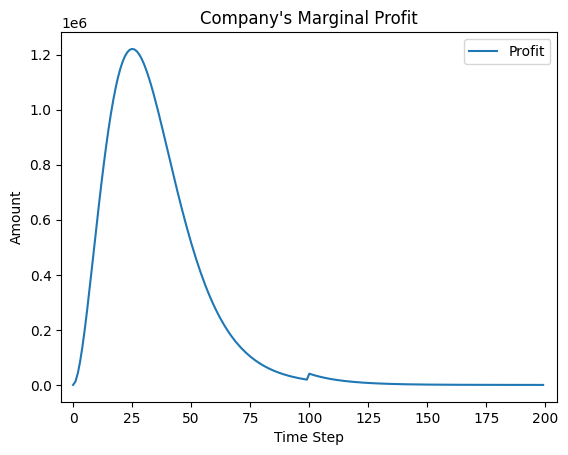

In [13]:
# Plot the company's marginal profit over time
marginal_profit = model.company.profit
plt.plot(range(200), marginal_profit, label="Profit")
#plt.plot(range(200), model.company.cost, label="Cost")
plt.xlabel("Time Step")
plt.ylabel("Amount")
plt.title("Company's Marginal Profit")
plt.legend()
plt.xlim(-5, 205)

plt.show()

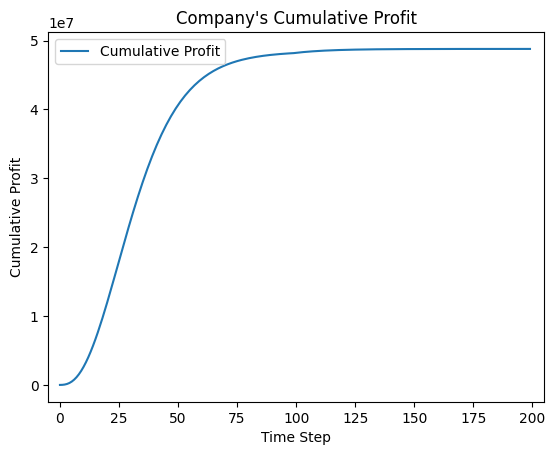

In [14]:
# Plot the company's profit over time
marginal_profit = model.company.profit
cumulative_profit = np.cumsum(marginal_profit)  # Calculate cumulative sum of profit

plt.plot(range(200), cumulative_profit, label="Cumulative Profit")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Profit")
plt.title("Company's Cumulative Profit")
plt.legend()
plt.xlim(-5, 205)  # Adjust x-axis limit if needed

plt.show()


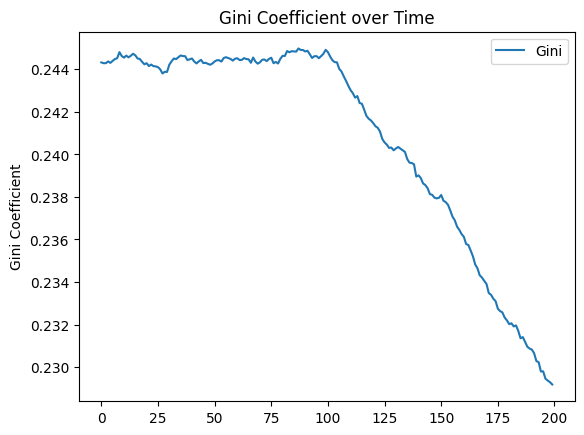

In [15]:
# Calculate the target metrics
gini = model.datacollector.get_model_vars_dataframe()

# Plot the Gini coefficient over time
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");